In [1850]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import NeuralNetwork as NN
import Layer
import importlib
importlib.reload(NN)
importlib.reload(Layer)

<module 'Layer' from '/Users/jorchard/Dropbox/research/peBogacz/python/Layer.py'>

In [1851]:
net = NN.NeuralNetwork()
l = Layer.InputPELayer(n=2)
net.AddLayer(l)
net.AddLayer(Layer.PELayer(n=2))
net.AddLayer(Layer.PELayer(n=2))
net.AddLayer(Layer.TopPELayer(n=2))

In [1852]:
net.SetIdentityWeights()
net.SetInput([1., 1])
net.SetExpectation([1., 1])
# net.layers[1].v[0] = 1.
# net.layers[2].v[0] = 1.
# net.layers[1].v[1] = 1.
# net.layers[2].v[1] = 1.


In [1853]:
net.ShowState()

Layer 0 (input):
  v = [1. 1.]
  e = [0. 0.]
Layer 1:
  v = [0. 0.]
  e = [0. 0.]
Layer 2:
  v = [0. 0.]
  e = [0. 0.]
Layer 3 (expectation):
  v = [1. 1.]


In [1854]:
net.ShowWeights()

  W01 = 
[[1. 0.]
 [0. 1.]]
  M10 = 
[[1. 0.]
 [0. 1.]]
  W12 = 
[[1. 0.]
 [0. 1.]]
  M21 = 
[[1. 0.]
 [0. 1.]]
  W23 = 
[[1. 0.]
 [0. 1.]]
  M32 = 
[[1. 0.]
 [0. 1.]]


In [1855]:
net.layers[-1].b = torch.zeros(2)
#for l in net.layers:
#    l.b[1] = 0.
net.layers[0].SetBias([0., 0.2384])
net.layers[1].SetBias([0.2384, 0.2384])
net.ShowBias()
net.learn = True
net.learn_weights = False
net.learn_biases = True

  b = [0.     0.2384]
  b = [0.2384 0.2384]
  b = [0.2384 0.2384]
  b = [0. 0.]


In [1856]:
T = 3
dt = 0.001
tt = np.arange(0, T, dt)

In [1857]:
net.Integrate()
net.layers[1].dbdt
net.Step(dt=0.001)
net.ShowState()

Layer 0 (input):
  v = [1. 1.]
  e = [0.001     0.0007616]
Layer 1:
  v = [0. 0.]
  e = [-0.004768 -0.004768]
Layer 2:
  v = [0. 0.]
  e = [-0.01999988 -0.01999988]
Layer 3 (expectation):
  v = [1. 1.]


In [1858]:
net.ShowBias()

  b = [0.     0.2384]
  b = [0.2384 0.2384]
  b = [0.2384 0.2384]
  b = [0. 0.]


In [1869]:
net.Run(T, dt=dt)
net.ShowState()
net.ShowBias()

Layer 0 (input):
  v = [1. 1.]
  e = [ 0.01346367 -0.00092788]
Layer 1:
  v = [1.0065962  0.99953187]
  e = [ 0.0056658  -0.00039446]
Layer 2:
  v = [1.0023663 0.9998283]
  e = [ 0.00239598 -0.0001672 ]
Layer 3 (expectation):
  v = [1. 1.]
  b = [0.22488098 0.23934658]
  b = [0.2384 0.2384]
  b = [0.2384 0.2384]
  b = [0. 0.]


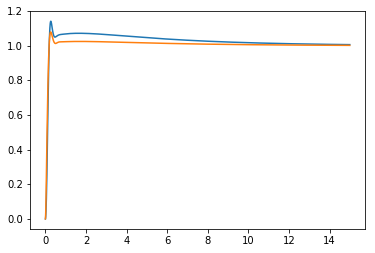

In [1870]:
plt.plot(np.array(net.t_history), np.array(net.layers[1].v_history)[:,0],
         np.array(net.t_history), np.array(net.layers[2].v_history)[:,0]);

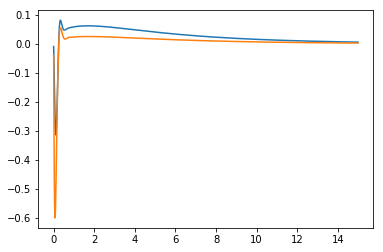

In [1871]:
plt.plot(np.array(net.t_history), np.array(net.layers[1].e_history)[:,0],
         np.array(net.t_history), np.array(net.layers[2].e_history)[:,0]);

In [1866]:
net.ShowWeights()

  W01 = 
[[1. 0.]
 [0. 1.]]
  M10 = 
[[1. 0.]
 [0. 1.]]
  W12 = 
[[1. 0.]
 [0. 1.]]
  M21 = 
[[1. 0.]
 [0. 1.]]
  W23 = 
[[1. 0.]
 [0. 1.]]
  M32 = 
[[1. 0.]
 [0. 1.]]


In [1867]:
net.ShowBias()

  b = [0.19348796 0.24148032]
  b = [0.2384 0.2384]
  b = [0.2384 0.2384]
  b = [0. 0.]
